#### Zillow Regression Analysis
**Artifact: Jupyter Notebook Report**

Created by: Mijail Q. Mariano

Wednesday, July 27th 2022

-----

In [1]:
# notebook dependencies
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# key libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from math import sqrt

# visualization libraries
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# created zillow .py files and functions
from prepare import display_all
import acquire
from acquire import get_zillow_dataset, \
            clean_zillow_dataset, \
            zillow_outliers, \
            plot_target, \
            plot_continuous, \
            plot_discrete, \
            train_validate_test_split, \
            select_kbest, \
            recursive_feature_eng

# sklearn library for modeling
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

----

### <u>**``Focal Analysis Questions:``**</u>

**Goal:** The purpose of this analysis is to explore a Zillow Real Estate dataset through visualizations and statistical tests to identify potential features that can accurately predict future tax assessed home values.

After exploring the Zillow dataset I design a machine learning (ML) model using regression techniques that predicts a home's tax assessed value with **~16% greater accuracy** than a baseline mean estimate.
<br></br>

**``Target Variable:``**
* Tax_Value_Dollar_Count = **"home value"**

<br></br>
**1. Does a home's location matter?**

I presume location matters in determining the final value/price of a home, as there could be economic factors (e.g., cost-of-living/inflationary considerations) that may be considered when assessing a home's relative value. Additionally, homes typically closer to metropolitan or labor producing areas may be more costly than rural/less-labor promoted areas.

* Homes closer to schools (predicted positive relationship)
* Home closer to parks/recreational areas (predicted positive relationship)
* Homes near hospitals/hospice care (predicted positive relationship)
* Areas with relatively less crime rates or high law-enforcement presence. (predicted negative relationship)
* Given the additional insurance costs/natural disaster considerations homes near bodies of water may be less attractive to home buyers. (predicted negative relationship)

``Relative Features:``
1. Fips
2. Latitude 
3. Longitude 
4. Parcel_id
5. Region_City_id
6. Region_id_County
7. Region_id_Zip


**2. Does home space matter?**

I presume that the larger the home (as measured by sq. ft.), the higher the home value will be. 

A larger home can be more attractive to home buyers since the space can act as both an initial family home, but also their “forever home”. Meaning that people who might not initially have a use for the additional space - may see the potential benefits of having it when they are ready to either 1. expand their family/or find use for the space or 2. View the space as a future investment for a buyer willing to pay the same or more for their spacious home in the future (investment thinking). 

* Consider the total number of baths 
* Consider the total number of bedrooms

``Relative Features:``
1. Calculated_Finished_Sq_Feet
2. Bathroom_Count
3. Bedroom_Count
4. Full_Bath_Count


**3. Does the home selling or purchase period matter?**

I presume that the period when a home is purchased or placed on the market will matter. Home buyers may be more reluctant to purchase a home in the colder regional months (e.g., typically winter) when the weather may be less favorable for moving. 

There may also be *renter factors or periods in the year when leases end and renters make the decision to purchase a home, subsequently driving more buyers to the market and thus potentially increasing home sale values. 

*(higher demand + “same” or not enough supply = more competition/higher home purchase price)*

* Consider seasonal patterns (e.g., summer months vs. winter) 

``Relative Features:``
1. Transaction_Date
2. Year_built
3. Assessment_Year


----
### **``Data Acquisition and Preparation``**

**``Key Highlights``**

- Used domain knowledge and research to focus on key questions for analysis
- Renamed and converted columns/features to proper type
- Dropped initial features with > 20% Null values
- Labeled and omitted homes with recorded finished sq. footage > 8K as larger/outlier homes*
- Focused on home values within the 90th percentile ~900K

*these homes represented homes larger than the majority homes in the dataset, therefore making the analysis or future prediction less accurate or obscured when including these records in the analysis.* *

In [2]:
# acquiring and preparing initial zillow dataset

df = get_zillow_dataset()
df = clean_zillow_dataset(df)
df = zillow_outliers(df)
df.shape

(49582, 13)

In [3]:
# confirming the dataset
df.head()

,home_value,bathroom_count,bedroom_count,living_sq_feet,fips_code,latitude,longitude,property_sq_feet,city_id,county_id,zip_code,year_built,purchase_date
0,562348.0,2.5,4,2088.0,6111.0,34238617.0,-118813281.0,6692.0,27110,2061,97118,1990,2017-01-05
1,444563.0,3.0,4,2572.0,6111.0,34235499.0,-118808366.0,10360.0,27110,2061,97118,1994,2017-01-05
2,613950.0,3.5,4,3213.0,6111.0,34243775.0,-118812925.0,11059.0,27110,2061,97118,1994,2017-01-05
3,622294.0,2.0,3,2170.0,6111.0,34244934.0,-118803182.0,10297.0,27110,2061,97118,1987,2017-01-05
4,538000.0,2.0,2,1457.0,6111.0,34247692.0,-118818283.0,8767.0,27110,2061,97118,1986,2017-01-05


In [4]:
# confirming the data types
pd.DataFrame(df.dtypes.sort_values()).rename(columns = {0: "data_type"})

,data_type
bedroom_count,int64
city_id,int64
county_id,int64
zip_code,int64
year_built,int64
home_value,float64
bathroom_count,float64
living_sq_feet,float64
fips_code,float64
latitude,float64


In [5]:
# summary statistics for continuous variables/features
summary_stats = df.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.round()

,count,mean,std,min,25%,50%,75%,max,range
home_value,49582.0,333952.0,204657.0,7584.0,173884.0,300256.0,461000.0,900000.0,892416.0
bathroom_count,49582.0,2.0,1.0,1.0,2.0,2.0,2.0,6.0,5.0
bedroom_count,49582.0,3.0,1.0,1.0,3.0,3.0,4.0,6.0,5.0
living_sq_feet,49582.0,1699.0,650.0,320.0,1233.0,1564.0,2038.0,7694.0,7374.0
fips_code,49582.0,6049.0,22.0,6037.0,6037.0,6037.0,6059.0,6111.0,74.0
latitude,49582.0,34022544.0,246268.0,33340711.0,33843744.0,34015136.0,34187271.0,34806946.0,1466235.0
longitude,49582.0,-118206586.0,351268.0,-119448392.0,-118392358.0,-118153320.0,-117953512.0,-117571939.0,1876453.0
property_sq_feet,49582.0,10113.0,87302.0,500.0,5623.0,6700.0,8188.0,6971010.0,6970510.0
city_id,49582.0,35749.0,55383.0,3491.0,12447.0,24812.0,42967.0,396556.0,393065.0
county_id,49582.0,2570.0,781.0,1286.0,2061.0,3101.0,3101.0,3101.0,1815.0


----
**``Initial Univariate Feature Analysis:``**

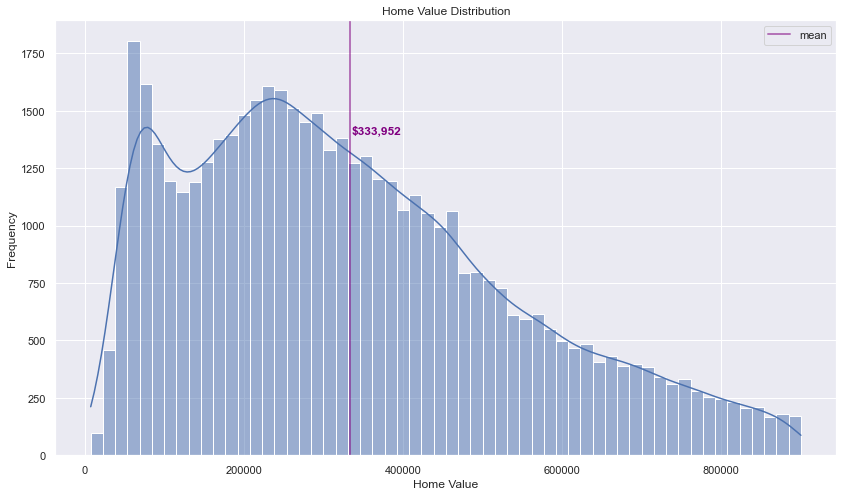

In [6]:
# exploring/visualizing the target - tax dollar home value ("home_value")

plt.figure(figsize = (14, 8))
sns.set(font_scale = 1)
ax = sns.histplot(df["home_value"], kde = True)

# removing axes scientific notation 
ax.ticklabel_format(style = "plain")

plt.axvline(df["home_value"].mean(), linewidth = 2, color = 'purple', alpha = 0.5, label = "mean")
plt.text(335500, 1400, "$333,952", horizontalalignment='left', size='medium', color='purple', weight='semibold')
plt.ylabel("Frequency")
plt.xlabel("Home Value")
plt.legend()
plt.title("Home Value Distribution")
plt.show()

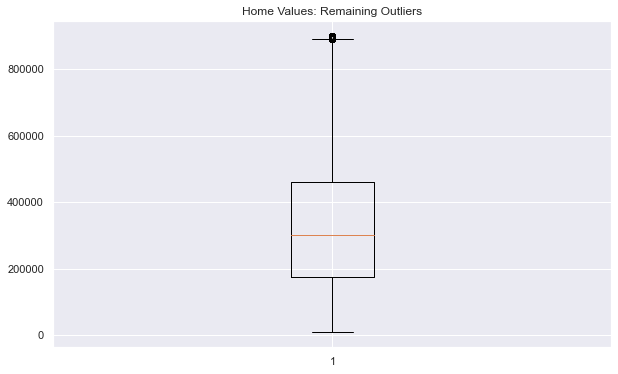

In [7]:
# home values box plot
plt.figure(figsize = (10, 6))
plt.boxplot(df["home_value"])

ax.set(xlabel = None)
plt.title("Home Values: Remaining Outliers")
plt.xlabel(None)
plt.show()

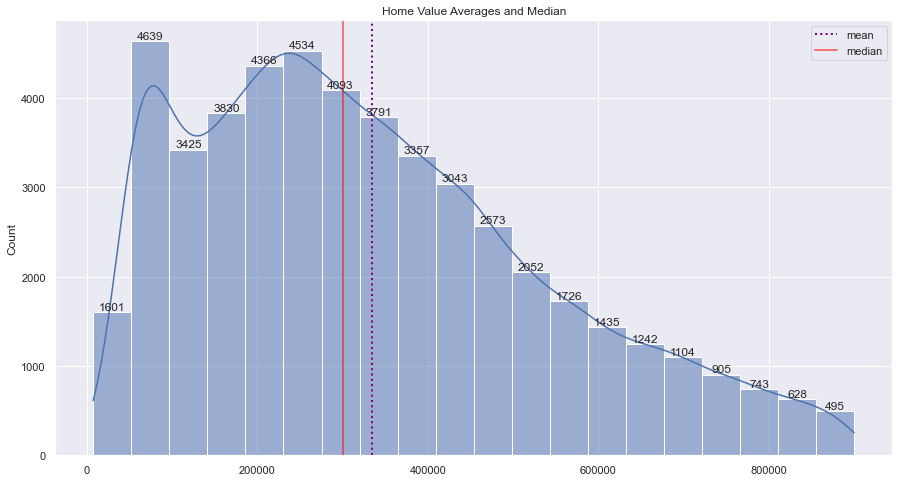

In [8]:
# total makeup of homes by ~45K value bin
plot_target(df["home_value"])

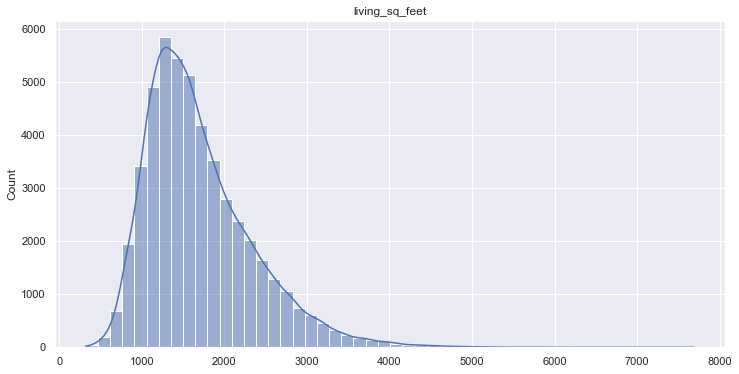

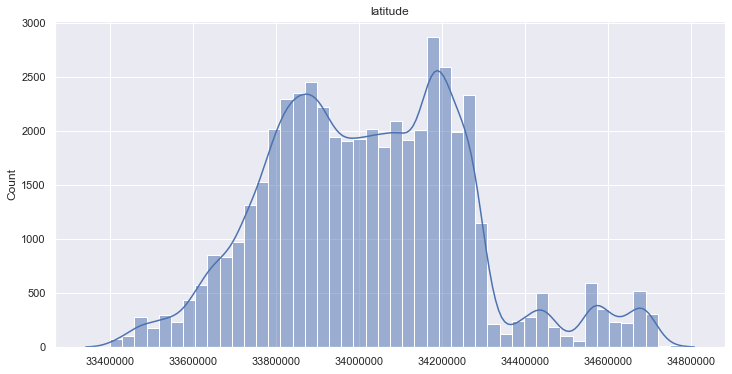

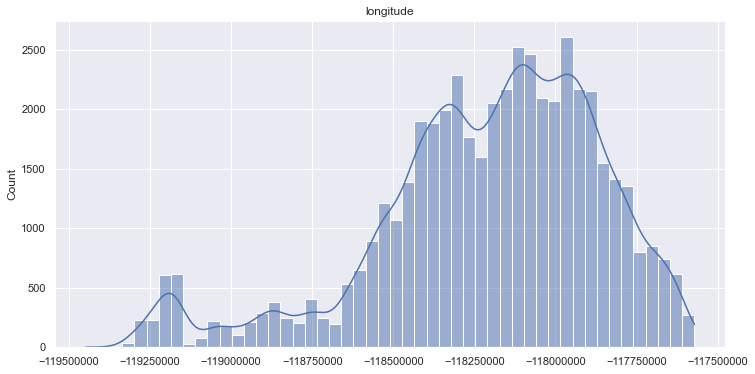

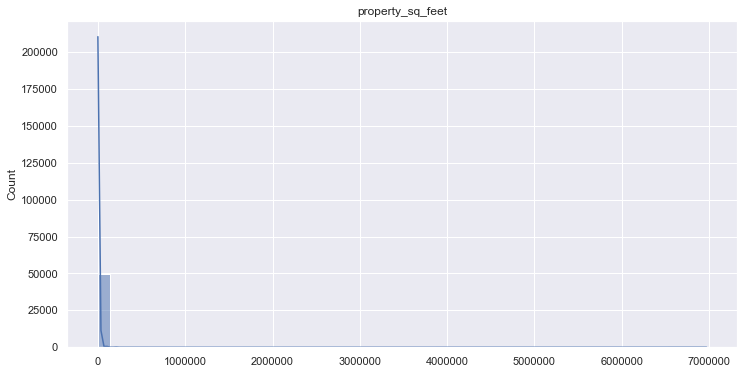

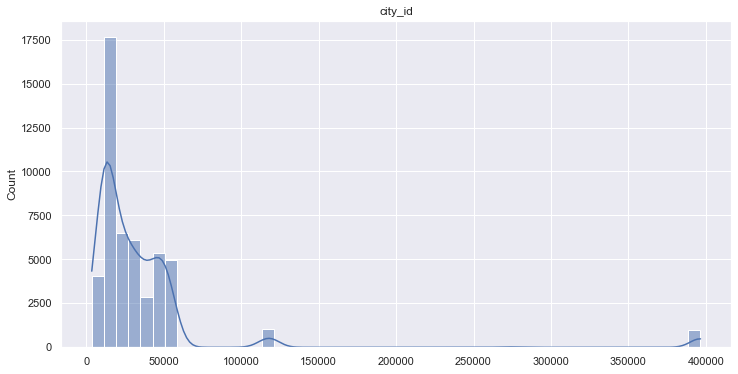

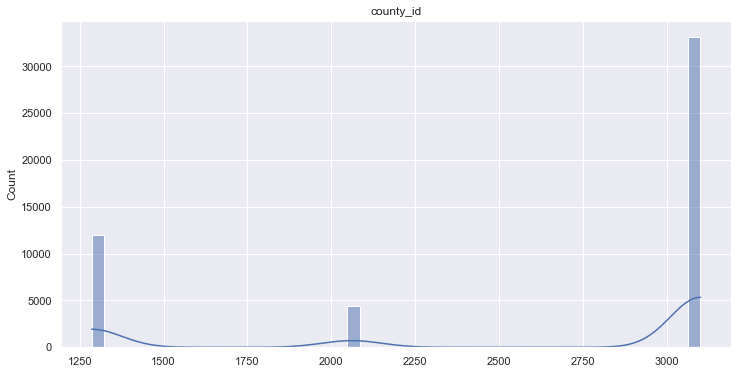

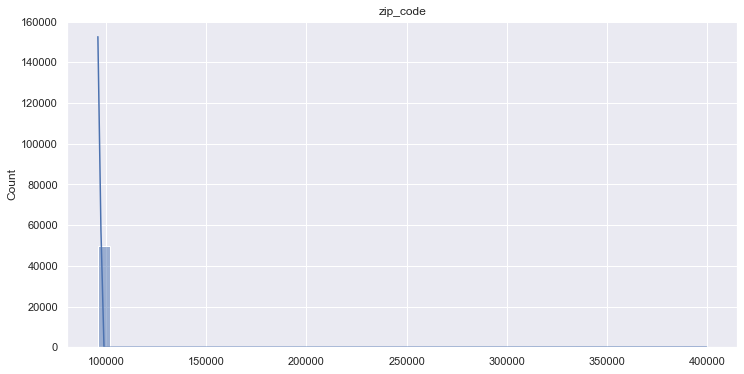

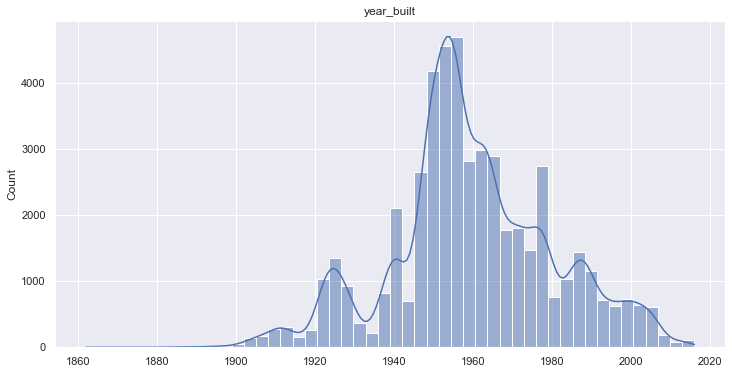

In [9]:
# plotting continuous/numerical features
plot_continuous(df)

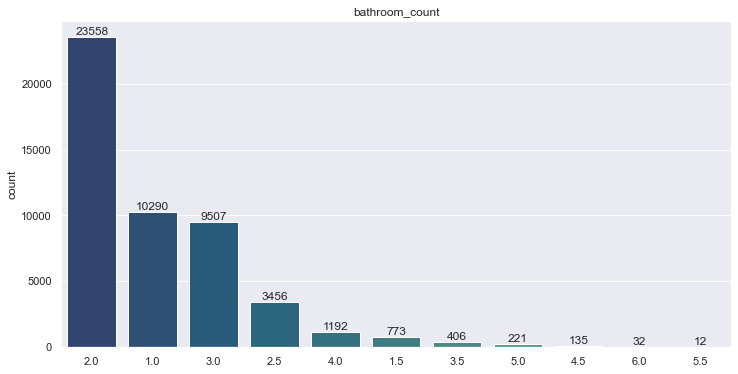

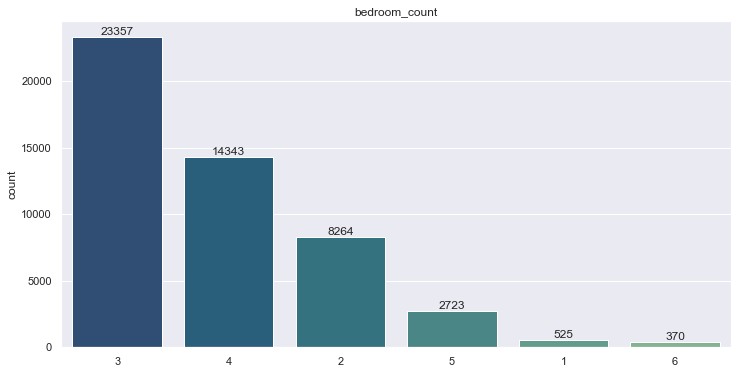

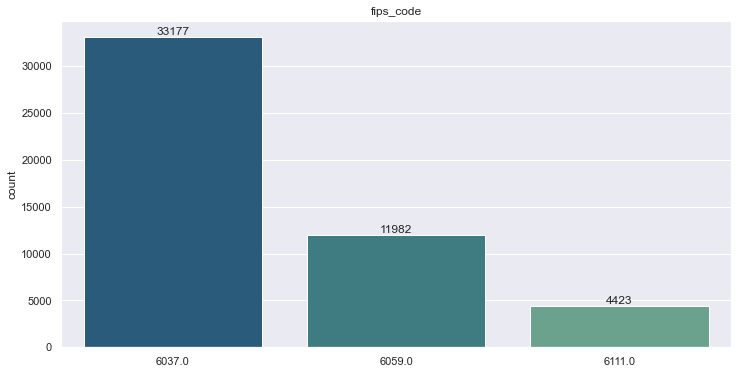

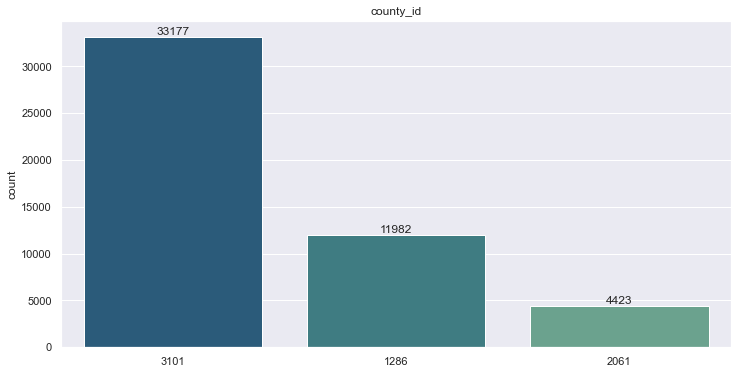

In [10]:
# plotting discreate/categorical features
plot_discrete(df)

<u>``Note on 'county_id':``</u>

* the sns.countplot for 'county_id' shows a 1for1 frequency match with fips_code
* omitting county_id as this is may be too closely associated with fips_code and is currently more ambigous in exact location

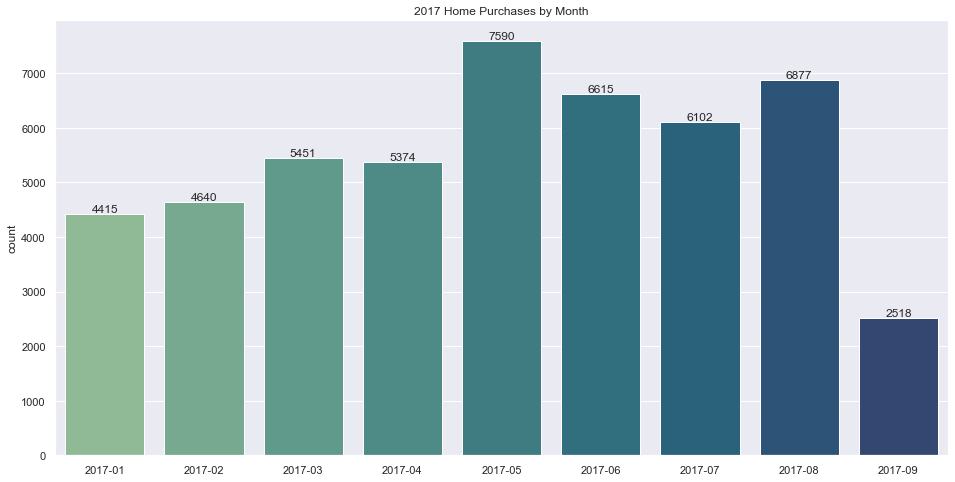

In [11]:
# creating a new feature/variable for month transaction/purchases in 2017
df = acquire.get_months_and_plot(df)

----
### <u>``Pre-processing the Data:``</u>

**``Highlights``**

- Established individual feature class (continuous/discrete)
- Generated new features potentially more descriptive of the data
- Created dummy columns/variables for discrete features
- Dropped redundant columns/features

In [12]:
unique_lst = []
for col in df.columns:
    if df[col].nunique() > 20:
        output = {
            'Feature': col,
            'Unique Values': df[col].nunique(),
            'Feature Class': "continuous"}
    else:
        output = {
            'Feature': col,
            'Unique Values': df[col].nunique(),
            'Feature Class': "discrete"}
    
    unique_lst.append(output)

pd.DataFrame(unique_lst).sort_values('Unique Values', ascending = False).reset_index(drop=True)

,Feature,Unique Values,Feature Class
0,longitude,48260,continuous
1,latitude,47914,continuous
2,home_value,38437,continuous
3,property_sq_feet,12371,continuous
4,living_sq_feet,3467,continuous
5,zip_code,377,continuous
6,purchase_date,246,continuous
7,city_id,175,continuous
8,year_built,133,continuous
9,bathroom_count,11,discrete


In [13]:
# creating a new column to calculate total number of elapsed years through current year
df = acquire.age_of_homes(df)

In [14]:
# creating column to clean up month-year column
df = acquire.clean_months(df)

In [15]:
# creating new columns for binning bathrooms and bedrooms
df = acquire.bin_bath_and_beds(df)
df.shape
# df.columns.tolist()

(49582, 20)

In [16]:
# creating new column for half baths
df = acquire.get_half_baths(df)
print(f'dataframe shape: {df.shape}')
df.columns.tolist()

dataframe shape: (49582, 21)


['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'fips_code',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'county_id',
 'zip_code',
 'year_built',
 'purchase_date',
 'purchase_month',
 'home_age',
 '1_to_3.5_baths',
 '4_to_6.5_baths',
 '1_to_2_bedrooms',
 '3_to_4_bedrooms',
 '5_to_6_bedrooms',
 'half_bathroom']

In [17]:
# Creating Dummy Columns/Variables for Discrete/Categorical Features
dummy_df = pd.get_dummies(data = df, columns = ['fips_code', 'purchase_month'])
df = dummy_df.copy()

In [18]:
# dropping redundant columns & 'county_id' column
df = acquire.drop_after_dummy(df)
print(f'New Dataframe W/Dummy Variables: {df.shape}')
df.columns.tolist()

New Dataframe W/Dummy Variables: (49582, 26)


['home_value',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'city_id',
 'zip_code',
 'home_age',
 '1_to_3.5_baths',
 '4_to_6.5_baths',
 '1_to_2_bedrooms',
 '3_to_4_bedrooms',
 '5_to_6_bedrooms',
 'half_bathroom',
 'fips_code_6037.0',
 'fips_code_6059.0',
 'fips_code_6111.0',
 'purchase_month_April',
 'purchase_month_August',
 'purchase_month_February',
 'purchase_month_January',
 'purchase_month_July',
 'purchase_month_June',
 'purchase_month_March',
 'purchase_month_May',
 'purchase_month_September']

-----
#### **Splitting Zillow Dataset for Exploration/Hypothesis Testing:**

In [19]:
train, validate, test = train_validate_test_split(df)

train shape: (27765, 26)
validate shape: (11900, 26)
test shape: (9917, 26)


In [20]:
# establishing a home value baseline prediction
train, validate = acquire.establish_baseline(train, validate)

Train baseline RMSE: 205092.78
Validate baseline RMSE: 204730.82

train shape: (27765, 26)
validate shape: (11900, 26)


In [21]:
# dataset subsplits (x and y variables)
X_train = train.drop(columns = "home_value")
y_train = train['home_value']

X_validate = validate.drop(columns = "home_value")
y_validate = validate['home_value']

X_test = test.drop(columns = "home_value")
y_test = test['home_value']

----
### **``Exploration and Hypothesis Testing``**

**<u>``One Sample T-test Hypothesis:``</u>**
* $H_0$ Null Hypothesis: The home value average for all feature values are the same
* $H_a$ Alternative Hypothesis: The home value average across feature values are different

**<u>``Pearson R Correlation Hypothesis:``</u>**
* $H_0$ Null Hypothesis: There is no linear correlation between the variables
* $H_a$ Alternative Hypothesis:  There is a linear correlation between variables

$alpha$: 0.05

<u>**Definitions:**</u>

The *"t_score"* is a ratio between the difference of two groups and the difference within the groups:
- Larger t_score = more difference between groups
- Smaller t_score = more similarity between groups

The *"p_value"* is the evidence against a null hypothesis: 

- Smaller p_value = the stronger the evidence that you should reject the null hypothesis


|feature|class|test|
|----|----|----|
|'bathroom-binned'|discrete|t-test|
|'bedroom-binned'|discrete|t-test|
|'fips_code'|discrete|t-test|
|'purchase_month|discrete|t-test|
|'living_sq_feet'|continuous|pearson-r|
|'latitude'|continuous|pearson-r|
|'longitude'|continuous|pearson-r|
|'property_sq_feet'|continuous|pearson-r|
|'city_id'|continuous|pearson-r|
|'zip_code'|continuous|pearson-r|
|'year_built'|continuous|pearson-r|
|'home_age'|continuous|pearson-r|


----

<Figure size 1080x432 with 0 Axes>

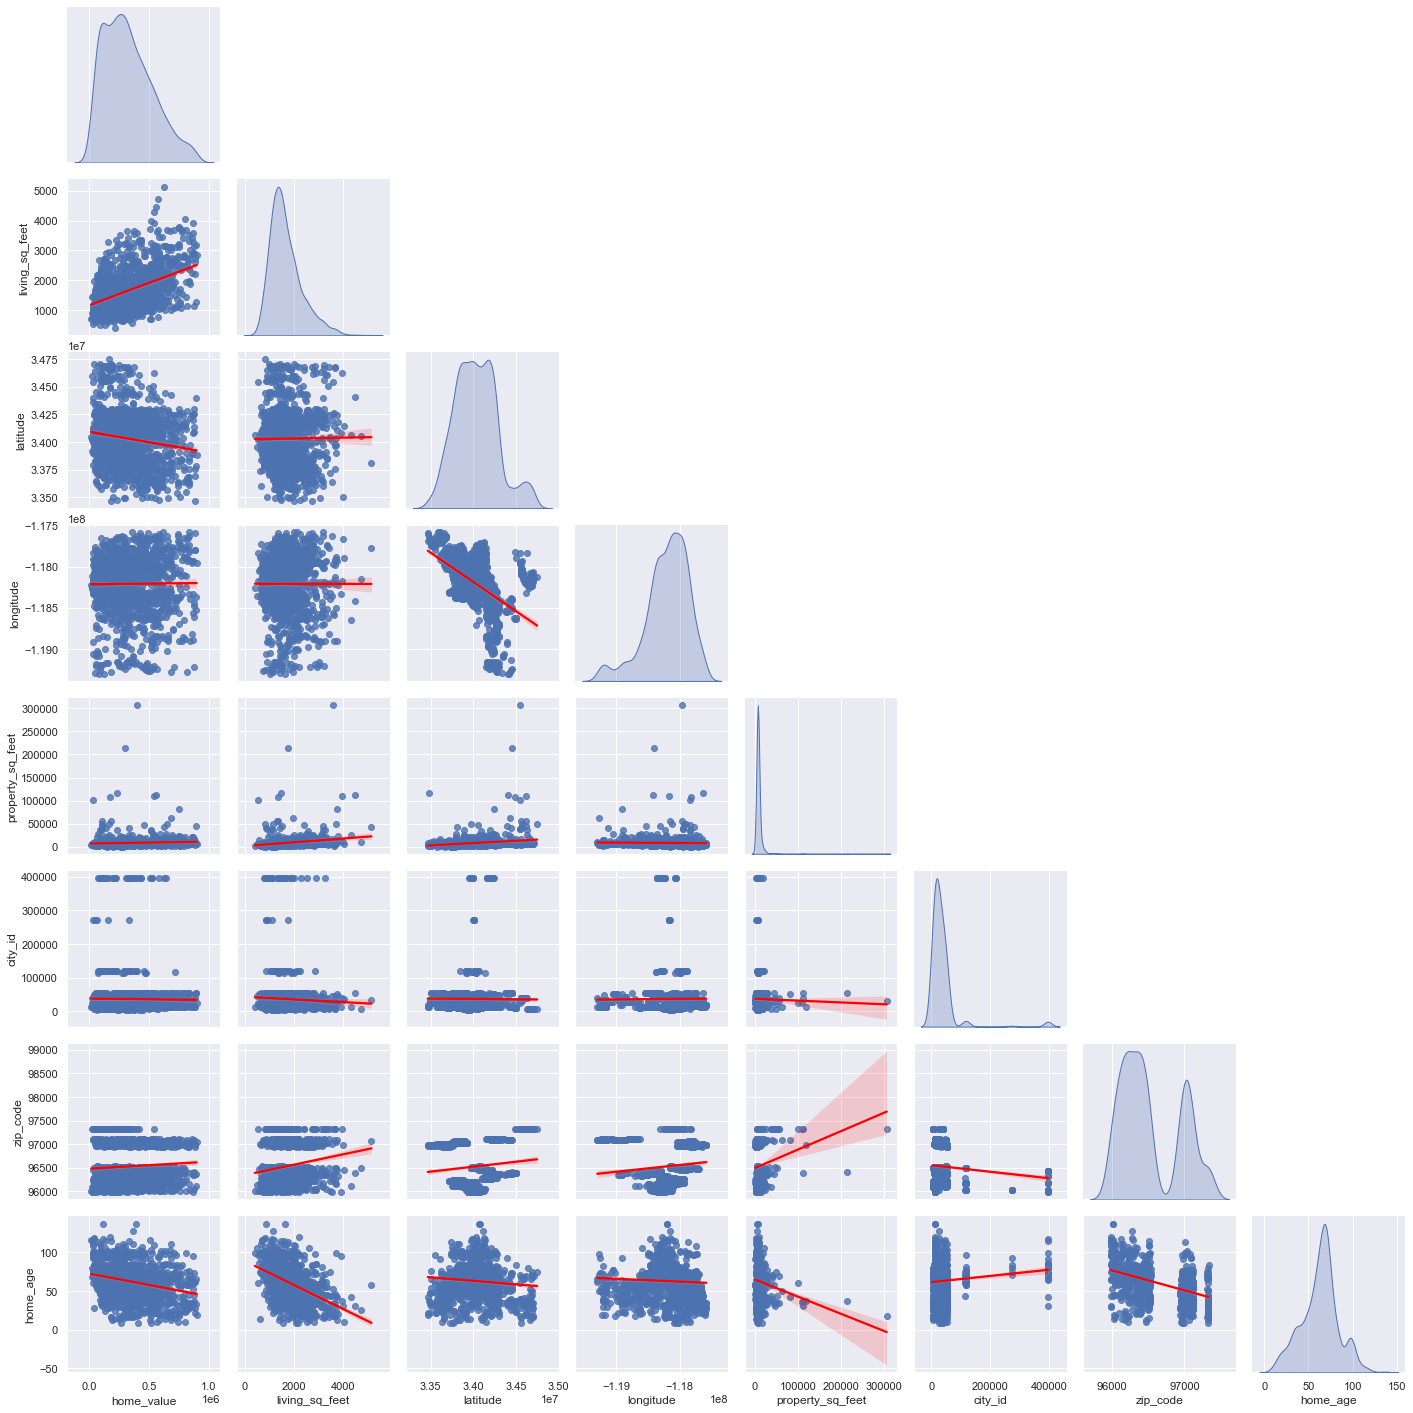

In [22]:
# plotting continuous variables against target
cont_lst = train.select_dtypes(exclude = ["bool", "uint8", "object"]).columns.tolist()
cont_df = train[cont_lst]
acquire.plot_variable_pairs1(cont_df)

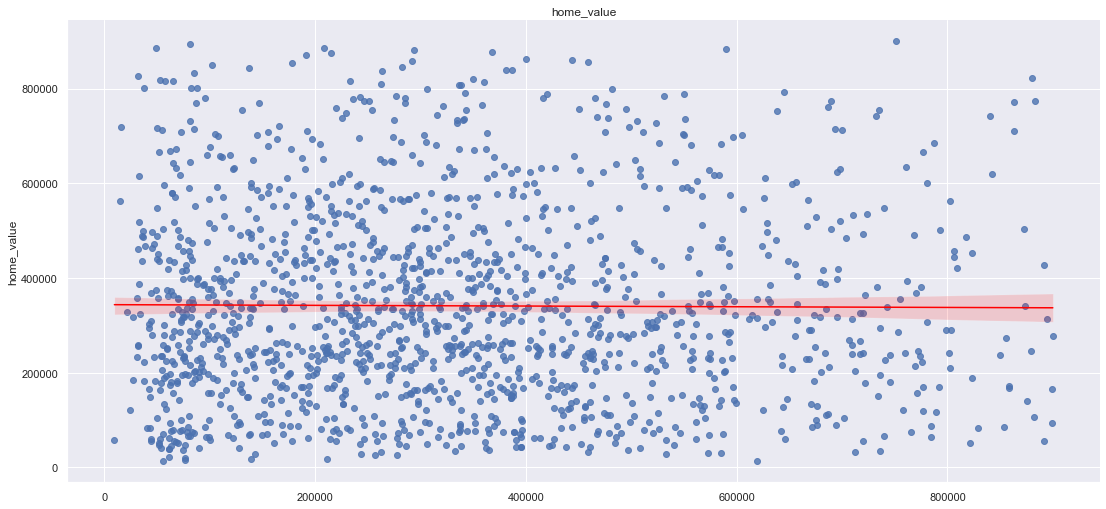

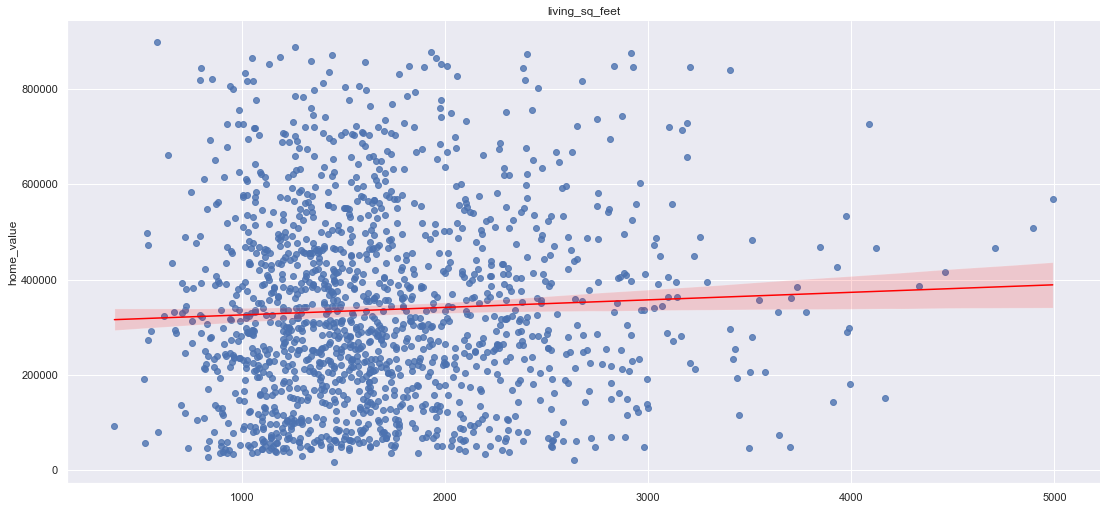

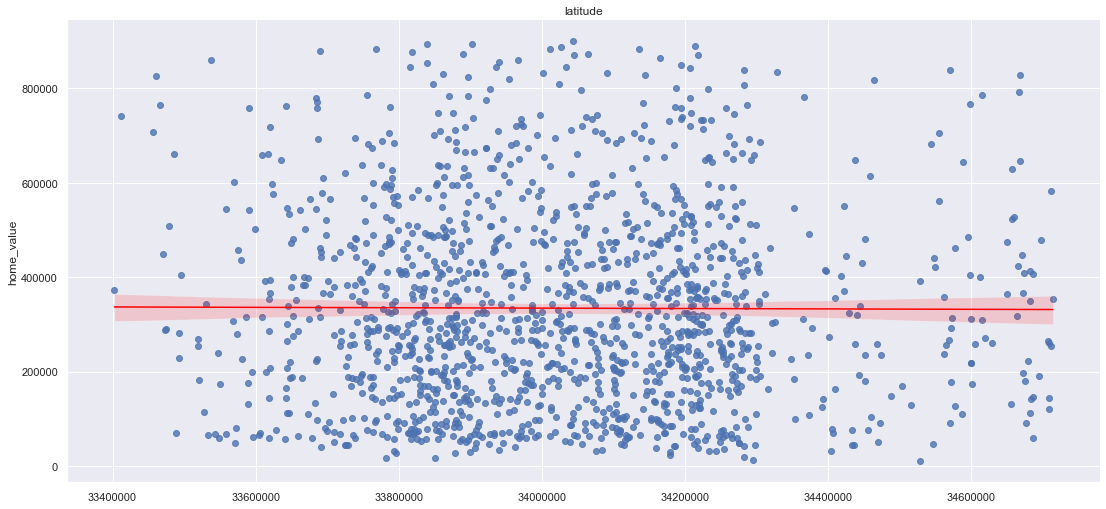

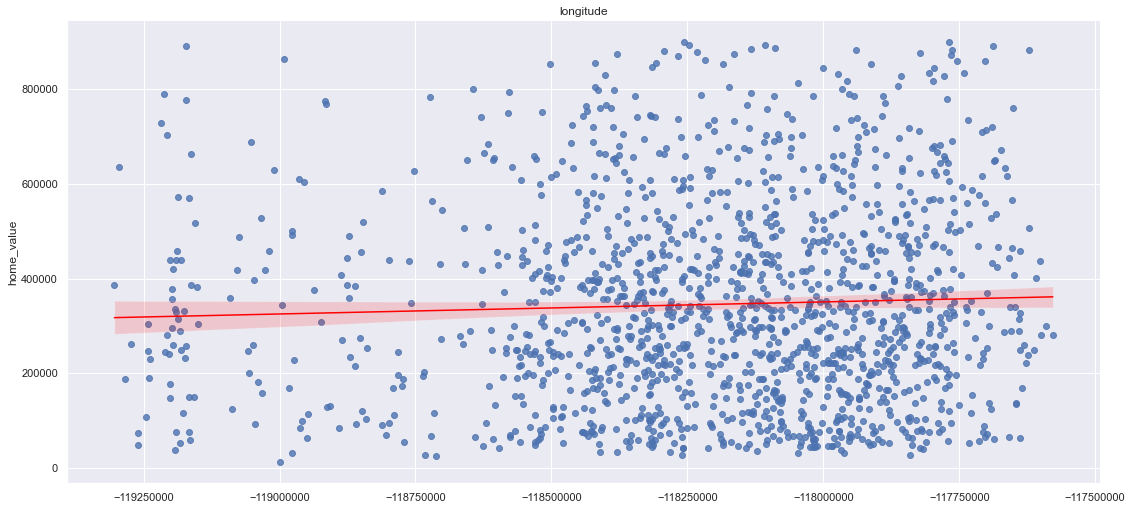

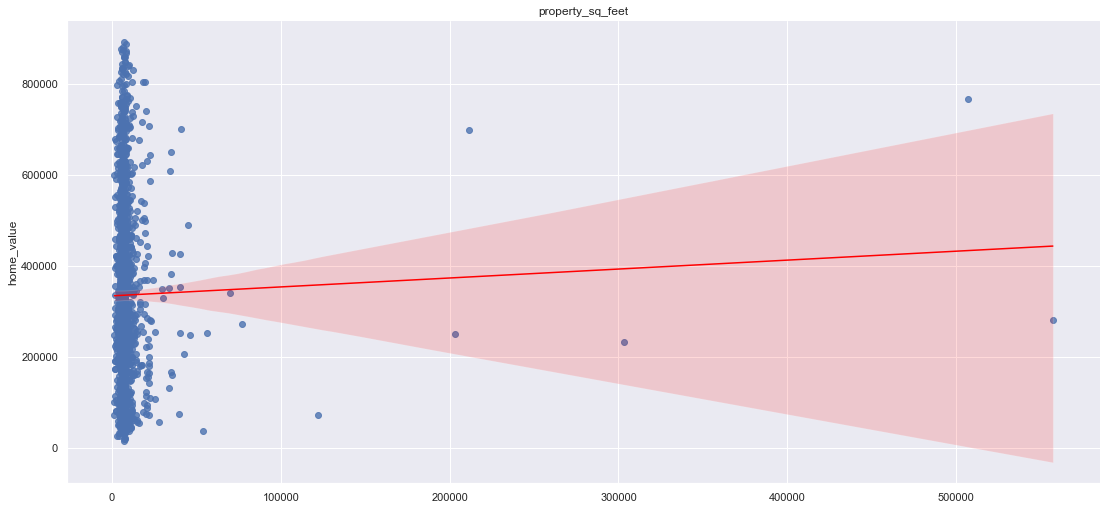

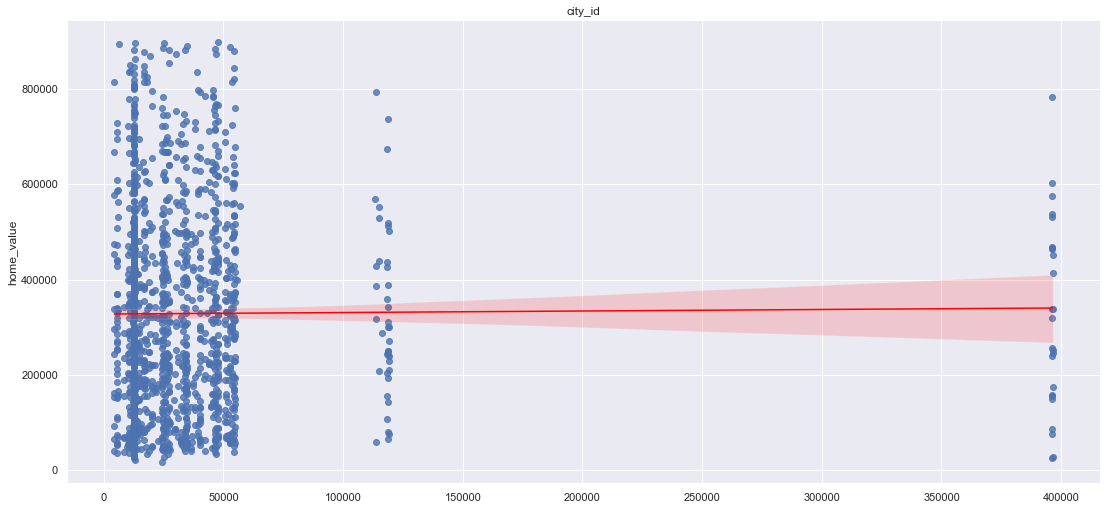

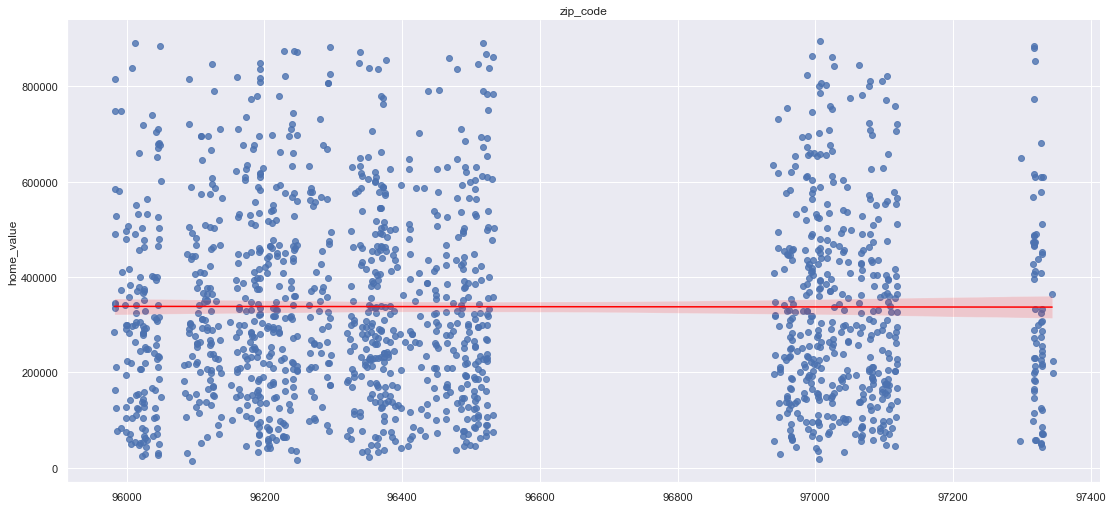

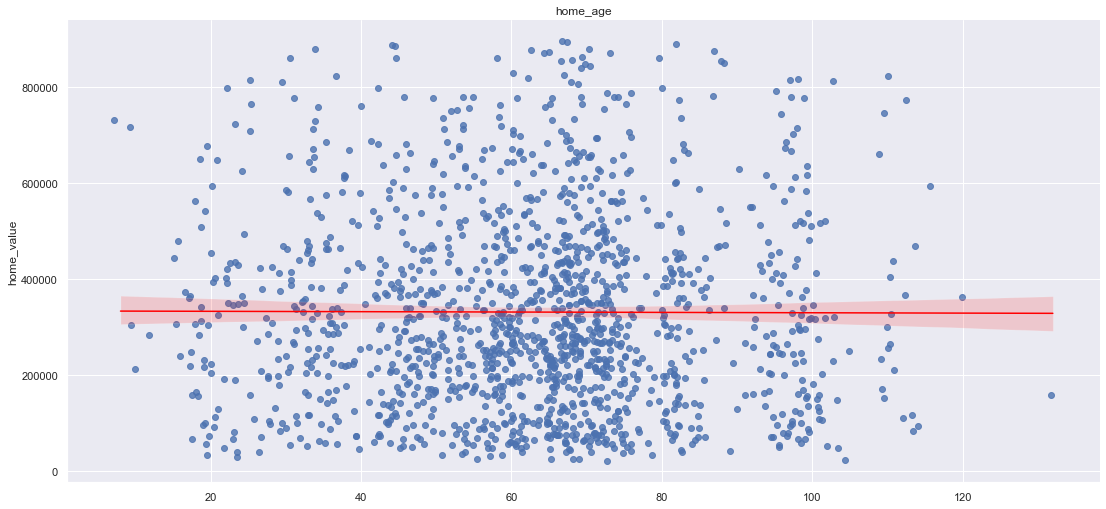

In [23]:
# plotting non-dummy variables against target
pair_lst = train.select_dtypes(exclude = ["bool", "uint8"]).columns.tolist()
acquire.plot_variable_pairs2(train, pair_lst)

In [24]:
cat_lst = train.select_dtypes(include = ["bool", "uint8"]).columns.tolist()
cont_lst = train.select_dtypes(exclude = ["object", "uint8", "bool"]).columns.tolist()

target_mean = round(y_train.mean(), 2)
alpha = 0.05

metrics = []
for col in cat_lst:
    sub_group = train[train[col] == 1].home_value
    t_score, p_value = stats.ttest_1samp(sub_group, target_mean)

    if p_value < alpha:
        output = {
            "discrete feature": col,
            "t_score": t_score,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col} not statistically significant.')
        print("---------------------------------------------------------------")

categorical_scores = pd.DataFrame(metrics)
categorical_scores.round(4)

Column: 4_to_6.5_baths not statistically significant.
---------------------------------------------------------------
Column: 3_to_4_bedrooms not statistically significant.
---------------------------------------------------------------
Column: 5_to_6_bedrooms not statistically significant.
---------------------------------------------------------------
Column: purchase_month_February not statistically significant.
---------------------------------------------------------------
Column: purchase_month_June not statistically significant.
---------------------------------------------------------------


,discrete feature,t_score,p_value
0,1_to_3.5_baths,-5.8721,0.0000
1,1_to_2_bedrooms,-25.5077,0.0000
2,half_bathroom,24.2692,0.0000
3,fips_code_6037.0,-16.7577,0.0000
4,fips_code_6059.0,20.5924,0.0000
5,fips_code_6111.0,8.6164,0.0000
6,purchase_month_April,6.6364,0.0000
7,purchase_month_August,-2.6040,0.0092
8,purchase_month_January,-4.3544,0.0000
9,purchase_month_July,5.4294,0.0000


In [25]:
target = train["home_value"]
alpha = 0.05

metrics = []

for col in cont_lst:
    r, p_value = stats.stats.pearsonr(train[col], target)

    if p_value < alpha:
        output = {
            "continuous feature": col,
            "correlation coeffficient": r,
            "p_value": p_value}
        
        metrics.append(output)

    else:
        print(f'Column: {col}')
        print(f'P_value: {round(p_value, 4)}')
        print('Not statistically significant.')
        print("---------------------------------------------------------------")

continuous_scores = pd.DataFrame(metrics)
continuous_scores.round(4)

Column: longitude
P_value: 0.1151
Not statistically significant.
---------------------------------------------------------------
Column: property_sq_feet
P_value: 0.498
Not statistically significant.
---------------------------------------------------------------
Column: city_id
P_value: 0.4247
Not statistically significant.
---------------------------------------------------------------
Column: zip_code
P_value: 0.153
Not statistically significant.
---------------------------------------------------------------


,continuous feature,correlation coeffficient,p_value
0,home_value,1.0000,0.0
1,living_sq_feet,0.4589,0.0
2,latitude,-0.1389,0.0
3,home_age,-0.2707,0.0


----
**``Statiscal Analysis/Conclusion Notes:``**

* Given the low/no statistical significance found in the following features or values, I elect to drop or disregard the following feature options in the datasets used in modeling. 
* Looking ahead, I will want to further examing/explore why these feature or options are considered "statistically insignificant" when determining "home_value".

<u>``Continuous features:``</u>
1. "city_id"
2. "property_sq_feet"
3. "longitude"
4. "zip_code"

<u>``Categorical/discrete values:``</u>
1. '4_to_6.5_baths'
2. '3_to_4_bedrooms'
3. '5_to_6_bedrooms'
4. 'purchase_month_February'
5. 'purchase_month_June'
6. 'county_id'*

In [26]:
print(f'X_train shape: {X_train.shape}')
print(f'X_validate shape: {X_validate.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (27765, 25)
X_validate shape: (11900, 25)
X_test shape: (9917, 25)


In [27]:
# cleaning independent feature datasets -- preparing for modeling:
X_train = acquire.clean_for_features(X_train)
X_validate = acquire.clean_for_features(X_validate)
X_test = acquire.clean_for_features(X_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_validate shape: {X_validate.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (27765, 16)
X_validate shape: (11900, 16)
X_test shape: (9917, 16)


----
### **``Modeling``**

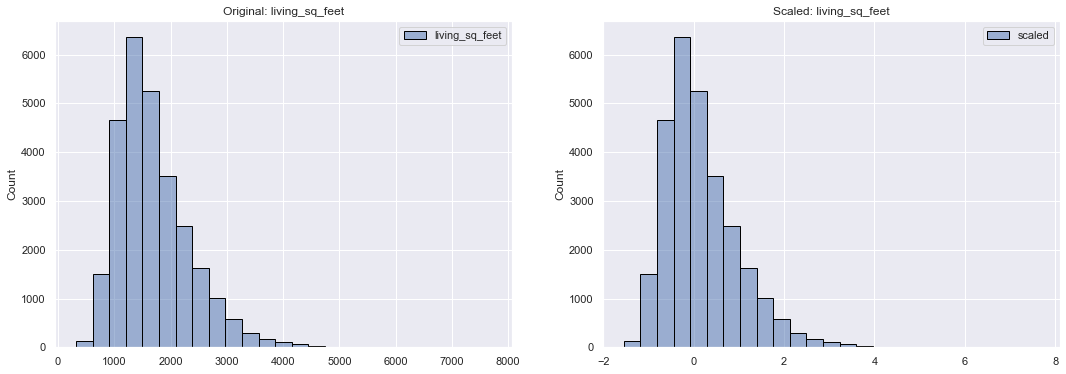

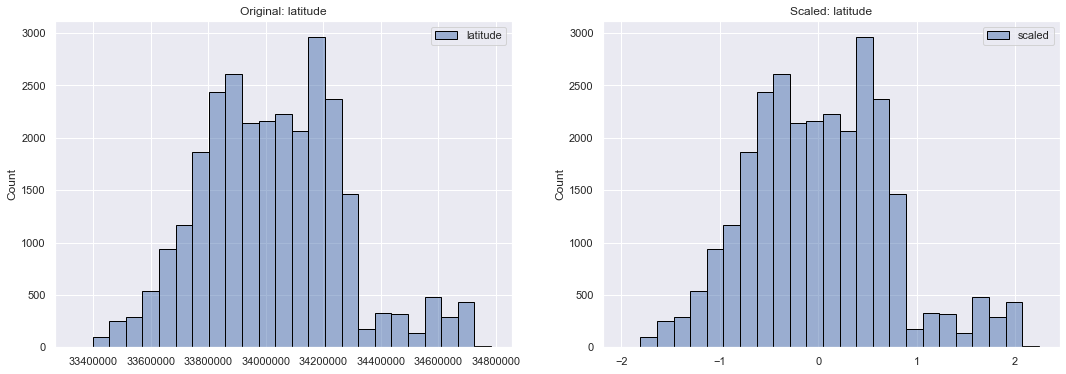

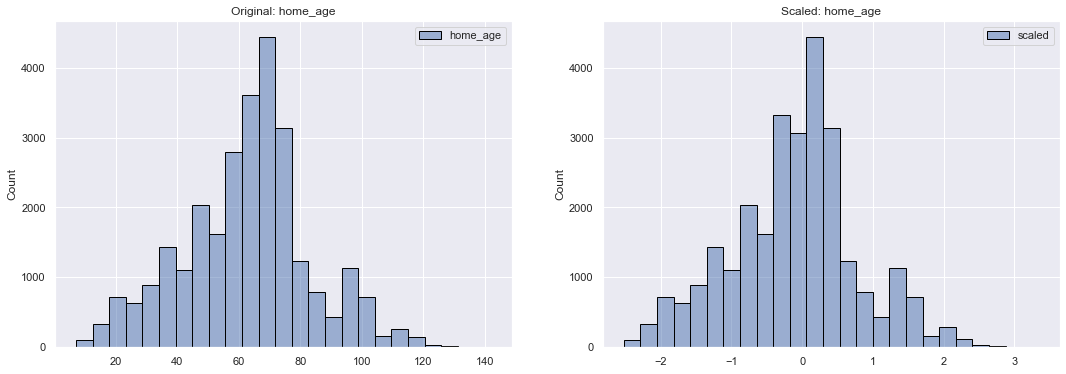

In [28]:
# distribution of continuous variables scaled: using SKlearn Robust Scaler
cont_lst = X_train.select_dtypes(exclude = ["object", "uint8", "bool"]).columns.tolist()

for col in cont_lst:
    scaler = RobustScaler()
    scaler.fit(X_train[[col]])

    x_scaled = scaler.transform(X_train[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    ax = sns.histplot(X_train[[col]], bins = 25, edgecolor = 'black', label = col)
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Scaled: {col}')
    plt.legend()

In [29]:
# scaling necessary features in datasets
scaler = RobustScaler()
scaler.fit(X_train[cont_lst])

X_train[cont_lst] = scaler.transform(X_train[cont_lst])
X_validate[cont_lst] = scaler.transform(X_validate[cont_lst])
X_test[cont_lst] = scaler.transform(X_test[cont_lst])

In [30]:
# confirming the scaling
X_train.home_age.describe() # checks out!

count    27765.000000
mean        -0.113142
std          0.893806
min         -2.521739
25%         -0.652174
50%          0.000000
75%          0.347826
max          3.347826
Name: home_age, dtype: float64

In [31]:
# Running K_best function for top 10 independent features in training dataset
pd.DataFrame(acquire.select_kbest(X_train, y_train, 10)).rename(columns = {0: "Feature"})

,Feature
0,living_sq_feet
1,latitude
2,home_age
3,1_to_3.5_baths
4,1_to_2_bedrooms
5,half_bathroom
6,fips_code_6037.0
7,fips_code_6059.0
8,fips_code_6111.0
9,purchase_month_April


In [32]:
# Running Sklearn Recursive Function for top 10 grouped functions in dataset
acquire.recursive_feature_eng(X_train, y_train, 10).reset_index(drop=True)

,Feature,Ranking
0,living_sq_feet,1
1,latitude,1
2,home_age,1
3,1_to_3.5_baths,1
4,1_to_2_bedrooms,1
5,half_bathroom,1
6,fips_code_6059.0,1
7,fips_code_6111.0,1
8,purchase_month_January,1
9,purchase_month_September,1


**``A Note on Sklearn's Feature Engineering "RFECV" Function``**

<u>**Cross-validation Estimator:**</u>

* An estimator that has built-in cross-validation capabilities to automatically select the best hyper-parameters. 
* Advantages of using a cross-validation estimator is that they can take advantage of warm-starting by reusing precomputed results in the previous steps of the cross-validation process. This generally leads to speed improvements. 
* By default, all these estimators, apart from RidgeCV with an LOO-CV, will be refitted on the full training dataset after finding the best combination of hyper-parameters.

<u>**Scorer:**</u>

* A non-estimator callable object which evaluates an estimator on given test data, returning a number. Unlike evaluation metrics, a greater returned number must correspond with a better score. See The scoring parameter: defining model evaluation rules.

In [33]:
# initiating and fitting Sklearn's RFECV feature selection function
RFECV = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 5)

RFECV = RFECV.fit(X_train, y_train)

In [34]:
# selected number of features
feature_lst = X_train.columns[RFECV.support_].tolist()
pd.DataFrame(feature_lst).rename(columns = {0: "Features"}).sort_values("Features").reset_index(drop=True)

,Features
0,1_to_2_bedrooms
1,1_to_3.5_baths
2,fips_code_6059.0
3,fips_code_6111.0
4,half_bathroom
5,home_age
6,latitude
7,living_sq_feet
8,purchase_month_April
9,purchase_month_August


**``Generating Models & Scoring against Train Dataset: Linear Regression, Lasso Lars, and Tweedie Regressor``**

In [35]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

lars = LassoLars()
lars_model = lars.fit(X_train, y_train)

glm = TweedieRegressor(alpha = 1, power = 0)
glm_model = glm.fit(X_train, y_train)

print("Training R-squared w/Linear Regression:", lr_model.score(X_train, y_train).round(4))
print("Training R-squared w/Lasso Lars:", lars_model.score(X_train, y_train).round(4))
print("Training R-squared w/Tweedie Regressor:", glm_model.score(X_train, y_train).round(4))

Training R-squared w/Linear Regression: 0.2442
Training R-squared w/Lasso Lars: 0.2442
Training R-squared w/Tweedie Regressor: 0.1655


**``Deploying Models on Validate Dataset: Mean Squared Error (MSE)``**

In [36]:
models = [lr_model, lars_model, glm_model]

for model in models:

    train_model = model.predict(X_train)
    rmse_train = sqrt(mean_squared_error(y_train,
                                         train_model))
    
    validate_model = model.predict(X_validate)
    rmse_validate = sqrt(mean_squared_error(y_validate,
                                         validate_model))
    
    print('RMSE for {} model on the train dataset: {}'.format(model, round(rmse_train, 2)))
    print('RMSE for {} model on the validate dataset: {}'.format(model, round(rmse_validate, 2)))
    print()

RMSE for LinearRegression() model on the train dataset: 178296.33
RMSE for LinearRegression() model on the validate dataset: 178929.99

RMSE for LassoLars() model on the train dataset: 178298.37
RMSE for LassoLars() model on the validate dataset: 178930.4

RMSE for TweedieRegressor(alpha=1, power=0) model on the train dataset: 187359.38
RMSE for TweedieRegressor(alpha=1, power=0) model on the validate dataset: 187403.24



-----
#### <u>**``Model Plots and Evaluation on Validate Dataset:``**</u>

In [37]:
# creating the independent and dependent variables
X_var = pd.DataFrame(X_validate[feature_lst])
y_var = pd.DataFrame(y_validate)
model_df = pd.concat([X_var, y_var], axis = 1).reset_index(drop = True)

# creating a home value mean baseline prediction
baseline_mean_predictions = round(y_validate.mean(), 2)
model_df["baseline_mean_predictions"] = baseline_mean_predictions

model_df.head()

,living_sq_feet,latitude,home_age,1_to_3.5_baths,1_to_2_bedrooms,half_bathroom,fips_code_6059.0,fips_code_6111.0,purchase_month_April,purchase_month_August,purchase_month_January,purchase_month_July,purchase_month_March,purchase_month_May,purchase_month_September,home_value,baseline_mean_predictions
0,0.364882,-0.678942,-0.086957,True,False,False,1,0,0,0,0,0,0,1,0,508180.0,334921.45
1,0.244085,-1.006109,-1.000000,True,True,True,1,0,1,0,0,0,0,0,0,371363.0,334921.45
2,-0.241594,0.512274,0.304348,True,True,False,0,0,0,0,0,0,0,0,1,297814.0,334921.45
3,-0.549191,-1.160618,-0.608696,True,False,False,1,0,0,1,0,0,0,0,0,195380.0,334921.45
4,-0.531756,0.438582,0.043478,True,True,False,0,0,1,0,0,0,0,0,0,371920.0,334921.45


In [38]:
# generating validate model predictions and assigning to dataframe
lr_predictions = lr_model.predict(X_validate)
model_df["linear_predictions"] = lr_predictions.round(2)

lars_predictions = lars_model.predict(X_validate)
model_df["lars_predictions"] = lars_predictions.round(2)

glm_predictions = lars_model.predict(X_validate)
model_df["glm_predictions"] = glm_predictions.round(2)

In [39]:
# generating error reports for all models and baseline:
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(model_df["home_value"], model_df["linear_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(model_df["home_value"], model_df["lars_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(model_df["home_value"], model_df["glm_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(model_df["home_value"], model_df["baseline_mean_predictions"])

linear_predictions SSE: 380989701806937.2
linear_predictions ESS: 121925990148160.58
linear_predictions TSS: 502915691955097.75
linear_predictions MSE: 32015941328.31405
linear_predictions RMSE: 178929.99001932025

lars_predictions SSE: 380991449134096.9
lars_predictions ESS: 121113406351053.28
lars_predictions TSS: 502104855485150.1
lars_predictions MSE: 32016088162.52915
lars_predictions RMSE: 178930.4003307687

glm_predictions SSE: 380991449134096.9
glm_predictions ESS: 121113406351053.28
glm_predictions TSS: 502104855485150.1
glm_predictions MSE: 32016088162.52915
glm_predictions RMSE: 178930.4003307687

baseline_mean_predictions SSE: 498784666610531.94
baseline_mean_predictions ESS: 0.2542016823832422
baseline_mean_predictions TSS: 498784666610532.2
baseline_mean_predictions MSE: 41914677866.43125
baseline_mean_predictions RMSE: 204730.74480016736


In [40]:
# acquiring melted model column for easier plotting
melt_df = acquire.get_melted_table(model_df)

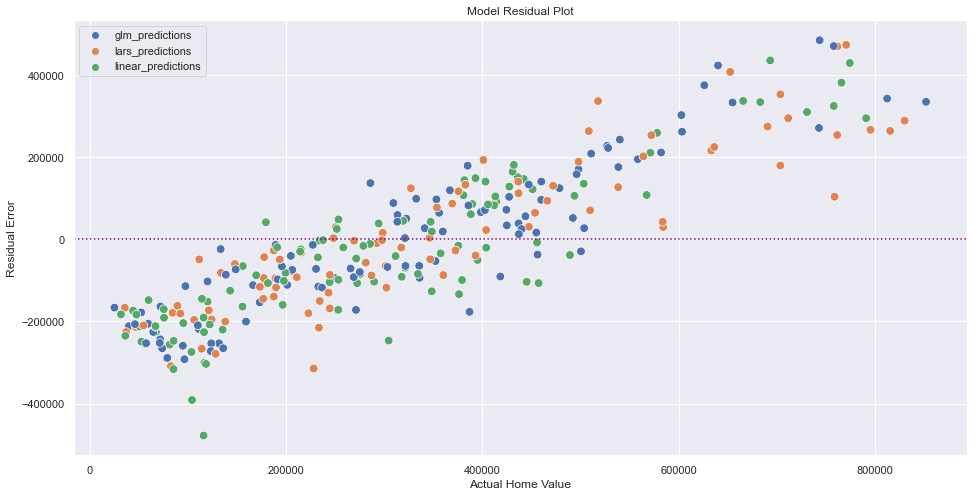

In [41]:
# plotting model residuals
acquire.plot_model_residuals(melt_df)

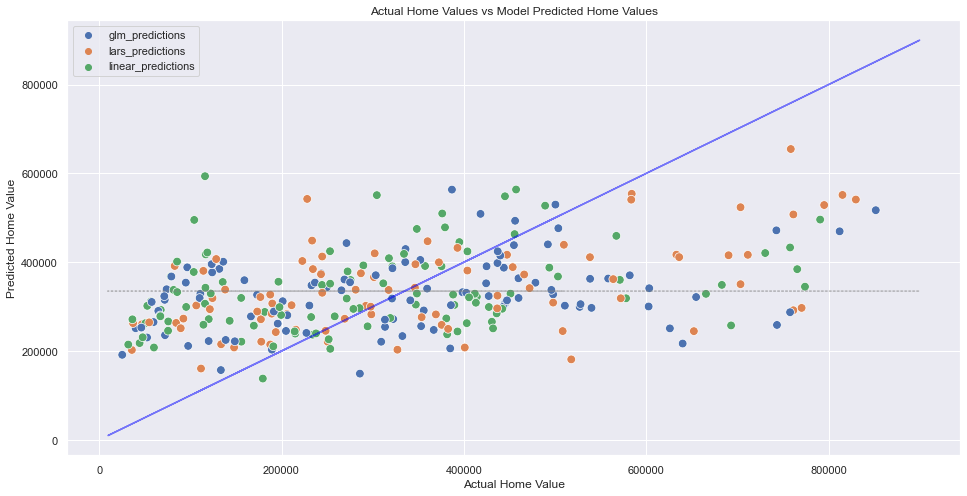

In [42]:
# plotting model predicted home values against target
acquire.plot_models(melt_df)

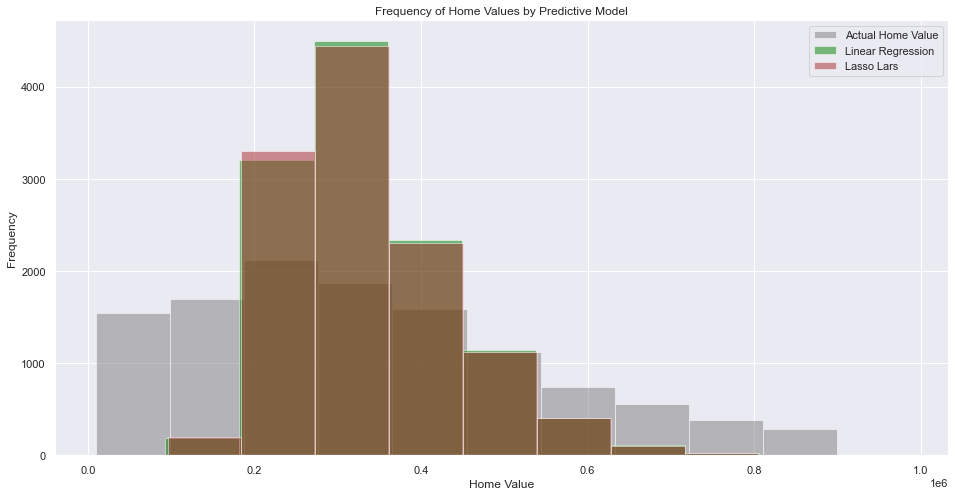

In [43]:
# Actual Home Values and Model Predicted Values
acquire.model_distributions(model_df)

### <u>``Deploying Linear Regression Model on Test Dataset:``</u>

In [44]:
# generating a dataframe
test_df = pd.DataFrame(y_test)

# generating model predictions
test_df["model_predictions"] = lr_model.predict(X_test).round(2)
test_df.head()

,home_value,model_predictions
52190,135438.0,444225.76
12407,306324.0,319716.05
42714,411754.0,368753.62
30367,54462.0,247827.25
23282,171907.0,191664.48


In [45]:
# returning R-squared score & RMSE on test dataset
rmse_test = sqrt(mean_squared_error(test_df['home_value'], test_df['model_predictions']))
print("Training R-squared w/Linear Model:", lr_model.score(X_test, y_test).round(4))
print(f'RMSE for OLS model on the test dataset: {round(rmse_test, 2)}')

Training R-squared w/Linear Model: 0.2405
RMSE for OLS model on the test dataset: 177150.56


In [46]:
# returning RMSE report 
acquire.final_rmse()

,Test,RMSE,Relative Diff.
0,Baseline,204730.70,0.00
1,Train,178296.33,0.15
2,Validate,178914.20,0.00
3,Final,177111.14,0.01


----
**<u>``Analysis Summary``</u>**

Overall, the linear regression model performed at ~16% better accuracy than a baseline mean home value predictor. Though not entirely conclusive of a home's tax assessed value - I believe this model may be able to handle fluctuations in the overall market particularly well. 

By using "binned" or categorical features in traditionally sought after home characteristics (e.g., bedrooms, bathrooms) to determine a home's value, the model helps to handle external factors such as seasonality/seasonal effects, cultural preferences, or demand shocks that can undoubtedly impact the number of 'for sale' homes available and subsquently, house prices in relatively short periods.


**``Recommendations:``**

1. Create a **Real-estate Training Program** that aims at helping Real-estate Brokers/Agents, Marketing, and Real-estate Consultancy teams to familiarize themselves with seasonal patterns in their local areas. By offering this program to real-estate professionals who are often closest to both sellers and buyers, it would help them to:

 - Better advise their clients on the most optimal periods to enter the market (purchase/sell their home)
 - More quickly recognize housing market shocks and make real-time decisions that help to normalize home value prices 

2. Use our online, mobile application, and advisory platforms to promote renovations of not just older homes, but smaller spaces and potentially converting them to **half-baths**. This feature along with more finished living space appears to be appealing characteristics for home buyers trading in traditional features such as the number of bedrooms or bathrooms for more efficient and univarsal home space.

----

**Looking Ahead (next steps):**

- Improve the model's predictive accuracy by identifying, testing, and including other potential home market factors 
    - regional cost-of-living indices
    - unemployment rates
    - educational/school ratings
    - crime rates
    - home design styles
<br></br>
- Calculate home/area distance to nearby metropolitan cities, park/recreational areas, schools, hospitals/hospice centers, etc.

- Parse out fips codes into more distinct locations either by towns/villages/neighborhoods or exact cities 